In [1]:
import torch
import os
import copy
import random
import timm
import wandb
import cv2
import torchmetrics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import pytorch_lightning as pl
import albumentations as A
import torch.optim.lr_scheduler as lr_scheduler

from datetime import datetime, timezone, timedelta
from PIL import Image
from sklearn.model_selection import train_test_split
from albumentations.pytorch.transforms import ToTensorV2
from tqdm import tqdm
from ipywidgets import interact

from torch.utils.data import DataLoader, Dataset
from torchmetrics.functional.classification import multilabel_accuracy
from torchmetrics.functional import accuracy


from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from pytorch_lightning.loggers import WandbLogger

pl.seed_everything(42)

Global seed set to 42


42

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
PROJECT_DIR = './Data'
os.chdir(PROJECT_DIR)

train = pd.read_csv('./train_label.csv')
val = pd.read_csv('./val_label.csv')
test = pd.read_csv('./test.csv')

In [4]:
def get_labels(df):
    return df.iloc[:, 2:].values

In [5]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        image = cv2.imread(img_path)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = torch.FloatTensor(self.label_list[index])
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [85]:
train_transform = A.Compose([
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            A.Resize(320, 320),
                            A.HorizontalFlip(p=0.5),
                            A.PixelDropout(dropout_prob=0.005, p=0.5),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            A.Resize(320, 320),
                            ToTensorV2()
                            ])

In [86]:
train_labels = get_labels(train)
train_dataset = CustomDataset(train['img_path'].values, train_labels, train_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


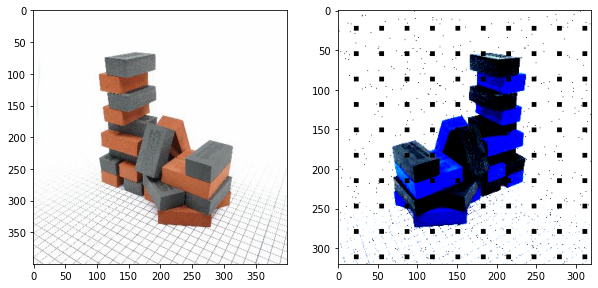

In [87]:
img, label = train_dataset[0]
image = cv2.imread(train.iloc[0].img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,6))

plt.subplot(1, 2, 1)
plt.imshow(image)

plt.subplot(1,2,2)
plt.imshow(img.permute(1,2,0))

# Test image

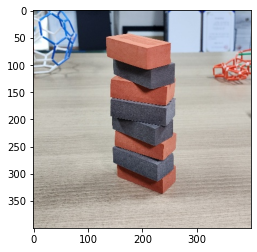

In [93]:
image = cv2.imread(test.iloc[4].img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8,4))
plt.imshow(image)

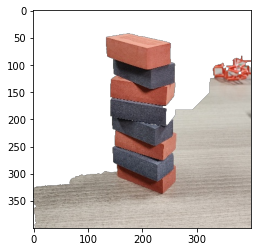

In [97]:
mask = np.zeros(image.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

rect = (1,1,420,420)
cv2.grabCut(image,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = image*mask2[:,:,np.newaxis]

tmp = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
b, g, r = cv2.split(img)
rgba = [b,g,r, alpha]
dst = cv2.merge(rgba,4)

plt.imshow(dst)